# Sound Pollution and How it Affects Natural Life in the Cities


Noise pollution not only affects people that live in urban settings, but also has a negative impact on natural life, especially on birds, affecting their calls and migrational patterns. The effect of noise pollution on bird populations have been significantly overlooked. Certain species are becoming endangered and have lost what used to be their native habitat. 
The Sounds of New York City (SONYC) project aims to bring awareness to the problem of noise pollution by deploying a network of acoustic sensors throughout the city to monitor and analyze noise pollution using machine listening. In this project, we focus on using audio recordings collected from the SONYC sensors to understand the effect of noise on birds, by contrasting bird calls with noise patterns near the Washington Square Park region. 
Understanding patterns of bird calls in comparison to noise levels is an important step towards recognizing the impact that increasing urban activities have on wildlife. Research on these topics can be used to discuss ways of mitigating sound pollution, and to inform new conservational schemes and urban policies to preserve natural life in cities. 


## What are the questions we are trying to answer?
####  Is there a relationship between frequency of noise pollutants (i.e. sounds from cars, trains, airplanes, ambulances, etc.) and the number of times bird calls can be heard or bird presence can be seen?
- Inverse effect: more other noises (other than birds), less bird noises
- Geographical, round map, sounds maps
- Also do the linear line graphs vs time (over time)
- Compare before and after situations (before and after lockdown)
#### Strength of other noises (SPL) vs. strength of bird calls?
- We get the combined SPL of both the type of noises
- Maybe we can try to separate SPL of low frequency vs SPL in general as SPL of high frequency can include birds, car horns, etc.
- Melody of bird noises (high frequency)
#### Are there certain times during the day when bird calls are more frequently heard than other noises?
##### (Maybe) Certain time of the year when there are more bird calls than other noises?
###### (Maybe) Certain time of the year when there are very few bird calls recorded?


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import csv
import h5py
from tqdm import tqdm
import sys
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from analysis_yamnet import (lineplot, add_in_weekend_shading, load_audio_data, compute_presence, 
                     presence_change_percentage, add_aligned_hour_index,
                     calculate_rolling_change_in_value)

In [2]:
# Checking the conda version
print(sys.executable)
print(sys.version)
print(sys.version_info)

/ext3/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)


Yamnet classes info: https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv

## Load data and shape for analysis

In [31]:
DATAPATH = '/scratch/mf3734/share/arise/data/'
AUDIO_DATAPATH = os.path.join(DATAPATH, "yamnet/")
NODE_INFOPATH = 'sonyc_node_info.csv'
#BIRD_SAMPLE_PATH = 'filelist.csv'

In [32]:
AUDIO_DATAPATH

'/scratch/mf3734/share/arise/data/yamnet/'

In [5]:
bird_related_classes = np.arange(106, 116)  # Position of bird related classes in yamnet predictions
bird_related_classes

array([106, 107, 108, 109, 110, 111, 112, 113, 114, 115])

In [6]:
classes_names = ['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet', 'Squawk', 'Pigeon, dove',
                 'Coo', 'Crow', 'Caw', 'Owl', 'Hoot']
classes_names_selection = ['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet']

In [7]:
important_dates = {
    'NYU classes online': datetime.date(2020, 3, 11),
    'Bars, restaurants closed': datetime.date(2020, 3, 16),
    'Non-essential bussines and housing closed': datetime.date(2020, 3, 22),
}

Filter sensors in WSP

In [8]:
node_info = pd.read_csv(NODE_INFOPATH).fillna(0)
near_park = node_info[node_info['near_park']==True]
near_park_list = [s for s in near_park[near_park['address'].str.contains('Washington')]['node_id']]
near_park_list

['sonycnode-b827eb815321.sonyc',
 'sonycnode-b827eb0fedda.sonyc',
 'sonycnode-b827eb905497.sonyc',
 'sonycnode-b827eb8e2420.sonyc']

In [9]:
node_info

,node_id,near_construction,on_thoroughfare,near_park,near_highway,near_commercial,nyu_location,height_ft,lat,lng,address,Borough
0,sonycnode-b827eb0d8af7.sonyc,0.0,1.0,0.0,0.0,1.0,1.0,25,40.729432,-73.993588,721 Broadway,Manhattan
1,sonycnode-b827eb815321.sonyc,0.0,0.0,1.0,0.0,0.0,1.0,6,40.731890,-73.997708,20 Washington Square N,Manhattan
2,sonycnode-b827eb4e7821.sonyc,0.0,0.0,0.0,0.0,0.0,1.0,20,40.730094,-73.994509,12 Waverly Pl,Manhattan
3,sonycnode-b827eb122f0f.sonyc,0.0,1.0,0.0,0.0,1.0,1.0,20,40.731403,-73.994565,30 E 8th St,Manhattan
4,sonycnode-b827eb0fedda.sonyc,0.0,0.0,1.0,0.0,0.0,1.0,20,40.730419,-73.998614,53 Washington Square S,Manhattan
5,sonycnode-b827eb132382.sonyc,0.0,1.0,0.0,0.0,1.0,1.0,25,40.727653,-73.993180,383 Lafayette St,Manhattan
6,sonycnode-b827ebefb215.sonyc,1.0,0.0,0.0,0.0,1.0,1.0,20,40.726368,-73.997083,194 Mercer St,Manhattan
7,sonycnode-b827eb905497.sonyc,0.0,0.0,1.0,0.0,0.0,1.0,25,40.729985,-73.997649,60 Washington Square S,Manhattan
8,sonycnode-b827eb42bd4a.sonyc,0.0,0.0,1.0,0.0,1.0,1.0,100,40.694443,-73.985477,5 MetroTech Center,Brooklyn
9,sonycnode-b827ebf31214.sonyc,0.0,0.0,0.0,0.0,1.0,1.0,25,40.730672,-73.999813,134 MacDougal St,Manhattan


In [10]:
# Format for name of the sensors
pat = 'sonycnode-(.+).sonyc'
prog = re.compile(pat)

In [11]:
sensors_wsp = [prog.match(s).group(1) for s in near_park_list]
sensors_wsp

['b827eb815321', 'b827eb0fedda', 'b827eb905497', 'b827eb8e2420']

In [13]:
df = pd.read_pickle(os.path.join(AUDIO_DATAPATH,'dataframe_yamnet.pkl'))

In [14]:
df

,sensor,timestamp,106,107,108,109,110,111,112,113,114,115
0,b827eb815321,1.488089e+09,9.975938e-03,1.128122e-03,3.919504e-04,8.508945e-06,9.052304e-03,4.817183e-03,1.383287e-03,2.363777e-04,9.896250e-04,3.756162e-05
1,b827eb815321,1.488089e+09,3.152194e-03,2.892717e-04,1.242938e-04,5.957219e-07,2.082371e-03,8.405432e-04,3.359333e-04,4.305603e-05,2.182464e-04,1.101918e-05
2,b827eb815321,1.488089e+09,6.539642e-04,5.412524e-05,1.961598e-05,3.332315e-10,2.323133e-04,7.404856e-05,6.589585e-06,2.266293e-06,2.969359e-06,6.663013e-07
3,b827eb815321,1.488089e+09,1.088048e-14,6.843630e-20,1.420090e-21,2.971111e-30,5.460059e-16,1.777473e-20,6.523317e-27,1.052115e-26,6.111985e-33,4.659873e-26
4,b827eb815321,1.488089e+09,2.285004e-27,8.439534e-37,0.000000e+00,0.000000e+00,1.054830e-29,1.438265e-38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
14,b827eb815321,1.585109e+09,9.580621e-12,1.302342e-15,3.506822e-17,9.154198e-26,7.224590e-13,2.864687e-16,6.282238e-23,5.046820e-24,4.064288e-27,2.500485e-23
15,b827eb815321,1.585109e+09,4.778940e-33,0.000000e+00,0.000000e+00,0.000000e+00,3.016485e-36,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
16,b827eb815321,1.585109e+09,4.789848e-28,3.746936e-37,0.000000e+00,0.000000e+00,3.822119e-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
17,b827eb815321,1.585109e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [15]:
df.sensor.unique()

array(['b827eb815321'], dtype=object)

In [33]:
# Load all sensors in WSP
dfs = []
for sensor_id in tqdm(sensors_wsp):
    print(sensor_id)
    print(os.path.join(AUDIO_DATAPATH,f'dataframe_yamnet_{sensor_id}.pkl'))
    # loading the dataframe for a given sensor
    _df = pd.read_pickle(os.path.join(AUDIO_DATAPATH,f'dataframe_yamnet_{sensor_id}.pkl'))
    # reshaping the table by adding temporal information
    _df = _df.groupby(['timestamp']).mean().reset_index()
    _df['sensor_id'] = sensor_id
    timestamps = np.char.array(_df['timestamp'].values)
    _df['datetime'] = pd.DatetimeIndex(pd.to_datetime(_df['timestamp'].astype('int'),
                                                              unit='s', utc=True)).tz_convert('America/New_York')
    _df['weekday'] = _df['datetime'].dt.weekday
    _df['hour_of_day'] = _df['datetime'].dt.hour
    _df['year'] = _df['datetime'].dt.year
    _df['date'] = _df['datetime'].dt.date
    del _df['timestamp']
    
     # Change columns names to more readable format
    _df.columns = classes_names + ['sensor_id', 'datetime', 'weekday', 'hour_of_day', 'year', 'date']
    _df.loc[_df['weekday'] < 5, 'period'] = 'weekday'
    _df.loc[_df['weekday'] >= 5, 'period'] = 'weekend'
    # add in years group
    _df.loc[(_df['year'] < 2020) & (_df['year'] >= 2017), 'year_group'] = '2017-2019'
    _df.loc[_df['year'] == 2020, 'year_group'] = '2020'

    id_cols = ['hour_of_day', 'date', 'datetime', 'year', 'weekday', 'sensor_id',
                   'year_group', 'period']

    _df = pd.melt(_df, id_vars=id_cols,
                     value_vars=classes_names,
                     value_name='likelihood',
                     var_name='sound_class')
    dfs.append(_df)
    
df = pd.concat(dfs, ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

b827eb815321
/scratch/mf3734/share/arise/data/yamnet/dataframe_yamnet_b827eb815321.pkl
Index(['106', '107', '108', '109', '110', '111', '112', '113', '114', '115',
       'sensor_id', 'datetime', 'weekday', 'hour_of_day', 'year', 'date'],
      dtype='object')


 25%|██▌       | 1/4 [00:03<00:10,  3.46s/it]

b827eb0fedda
/scratch/mf3734/share/arise/data/yamnet/dataframe_yamnet_b827eb0fedda.pkl
Index(['106', '107', '108', '109', '110', '111', '112', '113', '114', '115',
       'sensor_id', 'datetime', 'weekday', 'hour_of_day', 'year', 'date'],
      dtype='object')


 50%|█████     | 2/4 [00:07<00:07,  3.76s/it]

b827eb905497
/scratch/mf3734/share/arise/data/yamnet/dataframe_yamnet_b827eb905497.pkl
Index(['106', '107', '108', '109', '110', '111', '112', '113', '114', '115',
       'sensor_id', 'datetime', 'weekday', 'hour_of_day', 'year', 'date'],
      dtype='object')


 75%|███████▌  | 3/4 [00:11<00:03,  3.57s/it]

b827eb8e2420
/scratch/mf3734/share/arise/data/yamnet/dataframe_yamnet_b827eb8e2420.pkl
Index(['106', '107', '108', '109', '110', '111', '112', '113', '114', '115',
       'sensor_id', 'datetime', 'weekday', 'hour_of_day', 'year', 'date'],
      dtype='object')


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]


In [36]:
list_numbers = []
print(list_numbers)
for number in [1,2,3,4,5]:
    list_numbers.append(number)
    print(number)
print(list_numbers)

[]
1
2
3
4
5
[1, 2, 3, 4, 5]


In [37]:
df

,hour_of_day,date,datetime,year,weekday,sensor_id,year_group,period,sound_class,likelihood
0,1,2017-02-26,2017-02-26 01:00:05-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,5.073327e-03
1,1,2017-02-26,2017-02-26 01:01:15-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,7.583723e-04
2,1,2017-02-26,2017-02-26 01:02:12-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,3.577699e-03
3,1,2017-02-26,2017-02-26 01:03:07-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,1.704791e-02
4,1,2017-02-26,2017-02-26 01:04:01-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,1.159131e-04
...,...,...,...,...,...,...,...,...,...,...
4322395,23,2020-03-24,2020-03-24 23:55:53-04:00,2020,1,b827eb8e2420,2020,weekday,Hoot,5.636297e-08
4322396,23,2020-03-24,2020-03-24 23:56:49-04:00,2020,1,b827eb8e2420,2020,weekday,Hoot,9.673656e-09
4322397,23,2020-03-24,2020-03-24 23:57:48-04:00,2020,1,b827eb8e2420,2020,weekday,Hoot,2.714143e-09
4322398,23,2020-03-24,2020-03-24 23:58:52-04:00,2020,1,b827eb8e2420,2020,weekday,Hoot,7.404120e-06


In [39]:
df_bkp = df.copy()

# Analysis Starts Here

### Select three most general classes

In [49]:
df = df_bkp.copy()
# df = df[(df['sound_class'].isin(classes_names_selection))&(df['hour_of_day']>=4)&(df['hour_of_day']<=7)]
# Give me the part of the dataframe that is in this
df = df[(df['sound_class'].isin(classes_names_selection))]
#f = df[(df['sound_class'].isin(['Bird']))]

In [20]:
[df[df['year']==year]['datetime'].min() for year in range(2017,2021)]

[Timestamp('2017-02-26 01:00:05-0500', tz='America/New_York'),
 Timestamp('2018-03-02 06:26:04-0500', tz='America/New_York'),
 Timestamp('2019-02-24 00:00:35-0500', tz='America/New_York'),
 Timestamp('2020-02-24 00:02:09-0500', tz='America/New_York')]

In [21]:
[df[df['year']==year]['datetime'].max() for year in range(2017,2021)]

[Timestamp('2017-03-24 23:59:47-0400', tz='America/New_York'),
 Timestamp('2018-03-24 23:59:18-0400', tz='America/New_York'),
 Timestamp('2019-03-24 23:57:50-0400', tz='America/New_York'),
 Timestamp('2020-03-24 23:58:58-0400', tz='America/New_York')]

In [40]:
df['sensor_id'].unique()

array(['b827eb815321', 'b827eb0fedda', 'b827eb905497', 'b827eb8e2420'],
      dtype=object)

In [52]:
df['year'].unique()

array([2017, 2018, 2019, 2020])

In [50]:
df['sound_class'].unique()

array(['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet'],
      dtype=object)

In [51]:
df

,hour_of_day,date,datetime,year,weekday,sensor_id,year_group,period,sound_class,likelihood
0,1,2017-02-26,2017-02-26 01:00:05-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,0.005073
1,1,2017-02-26,2017-02-26 01:01:15-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,0.000758
2,1,2017-02-26,2017-02-26 01:02:12-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,0.003578
3,1,2017-02-26,2017-02-26 01:03:07-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,0.017048
4,1,2017-02-26,2017-02-26 01:04:01-05:00,2017,6,b827eb815321,2017-2019,weekend,Bird,0.000116
...,...,...,...,...,...,...,...,...,...,...
3460807,23,2020-03-24,2020-03-24 23:55:53-04:00,2020,1,b827eb8e2420,2020,weekday,"Chirp, tweet",0.000008
3460808,23,2020-03-24,2020-03-24 23:56:49-04:00,2020,1,b827eb8e2420,2020,weekday,"Chirp, tweet",0.000003
3460809,23,2020-03-24,2020-03-24 23:57:48-04:00,2020,1,b827eb8e2420,2020,weekday,"Chirp, tweet",0.000002
3460810,23,2020-03-24,2020-03-24 23:58:52-04:00,2020,1,b827eb8e2420,2020,weekday,"Chirp, tweet",0.000077


## Explore activations at different hours of the day

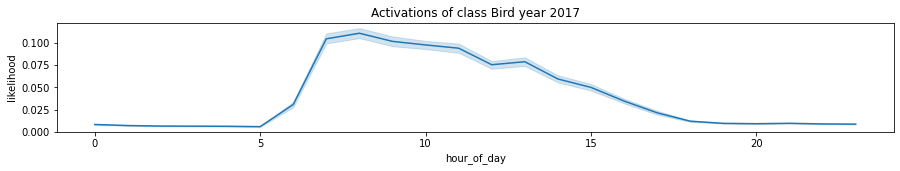

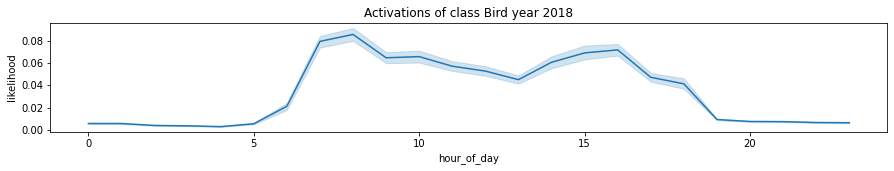

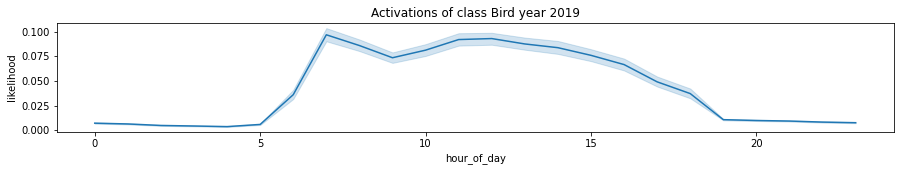

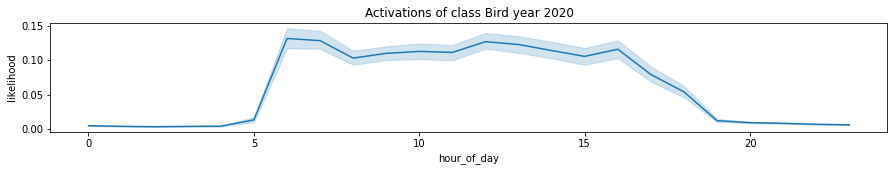

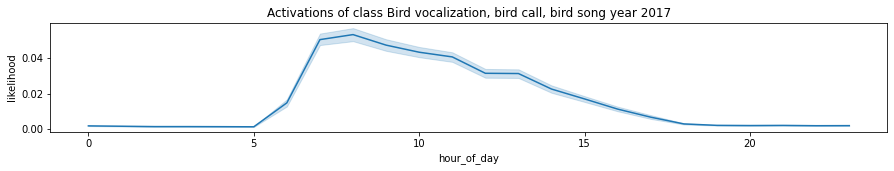

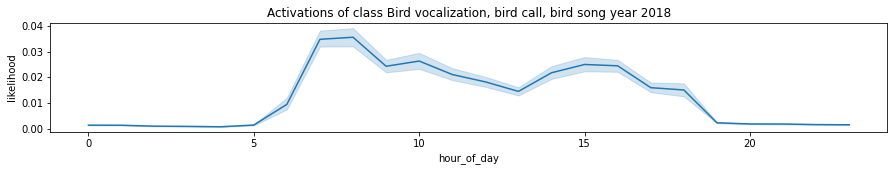

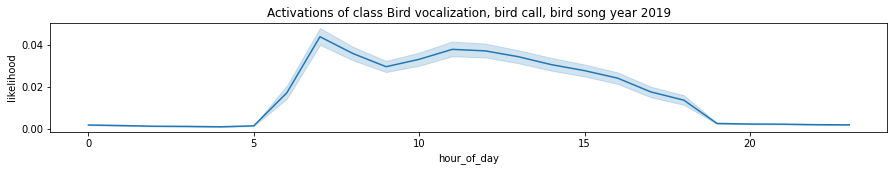

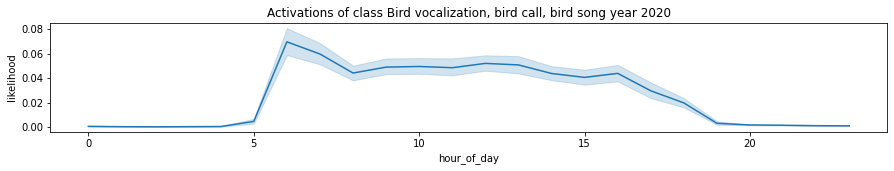

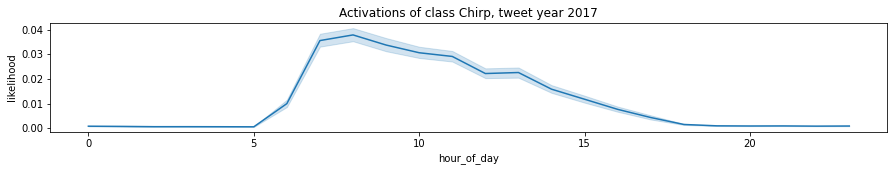

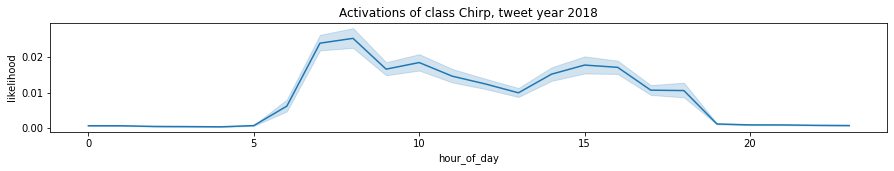

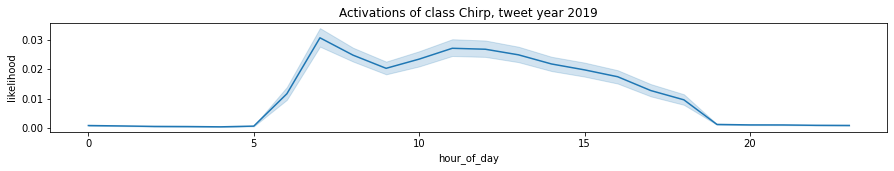

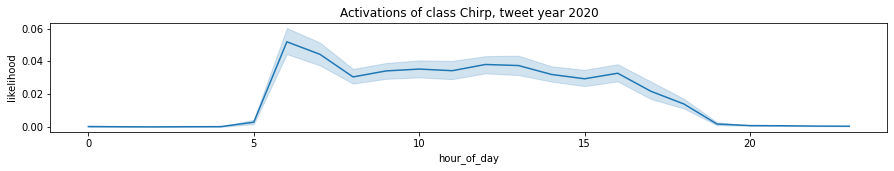

In [24]:
for sound_class in df['sound_class'].unique():
    for year in df['year'].unique():
        _df_ = df[(df['year']==year)&(df['sound_class']==sound_class)]
        plt.figure(figsize=(15,2))
        sns.lineplot(data=_df_, x='hour_of_day', y='likelihood')
        plt.title(f'Activations of class {sound_class} year {year}')
        plt.show()

It seems that for most classes the activity starts around 5.30AM until 7PM, which makes sense. For the Bird class a good threshold seems to be 0.02, and there seem to be a lot of redundancy in the classes. May be enough simply to look at the first three-four classes. Compare presence estimation only Bird class vs. all classes, is there much difference? 

In [25]:
quick_ths = {}
for sound_class in df['sound_class'].unique():
    for year in df['year'].unique():
        _df_ = df[(df['year']==year)&(df['sound_class']==sound_class)]
        quick_ths[sound_class] = np.median(_df_['likelihood'])
print(quick_ths)

{'Bird': 0.012460522, 'Bird vocalization, bird call, bird song': 0.002733344, 'Chirp, tweet': 0.0013716845}


In [26]:
quick_ths = {'Bird': 0.026604839, 'Bird vocalization, bird call, bird song': 0.006209028, 'Chirp, tweet': 0.003550415, 'Squawk': 2.2587024e-06, 'Pigeon, dove': 0.0038214554, 'Coo': 0.003757548, 'Crow': 0.0024405327, 'Caw': 0.0007486704, 'Owl': 0.0019189504, 'Hoot': 2.1393362e-05}

## Compute change per class

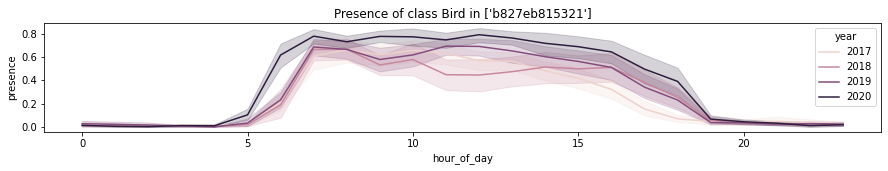

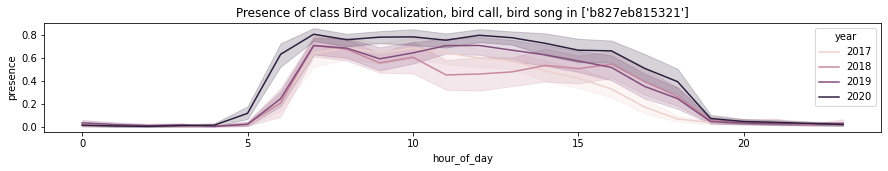

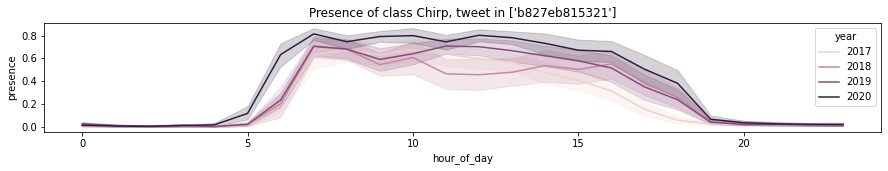

In [27]:
for sound_class in df['sound_class'].unique():
#     for year in _df['year'].unique():
    _df_perclass = df[df['sound_class']==sound_class]
    _df_perclass = compute_presence(_df_perclass, quick_ths)
    plt.figure(figsize=(15,2))
    sns.lineplot(data=_df_perclass, x='hour_of_day', y='presence', hue='year')
    plt.title(f"Presence of class {sound_class} in {df['sensor_id'].unique()}")
    plt.show()

Bird


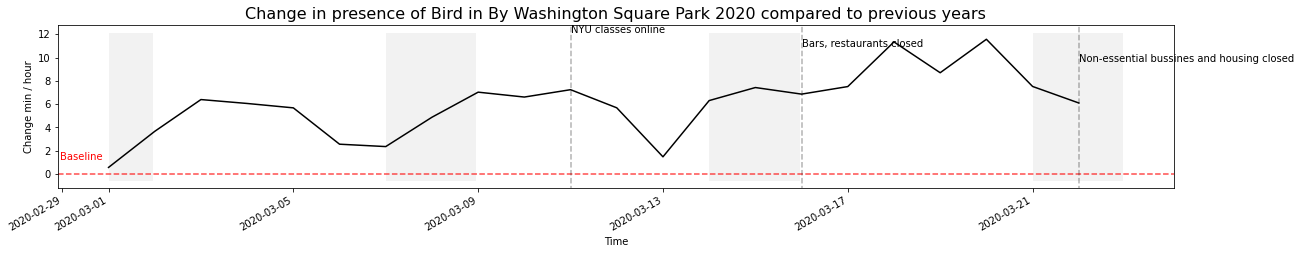

Bird vocalization, bird call, bird song


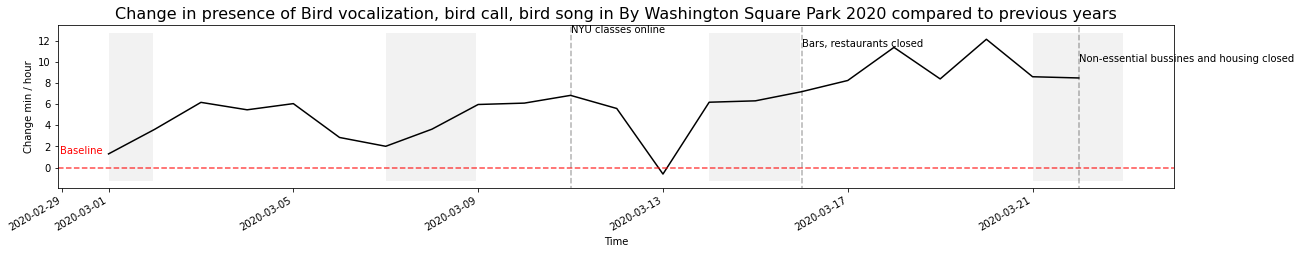

Chirp, tweet


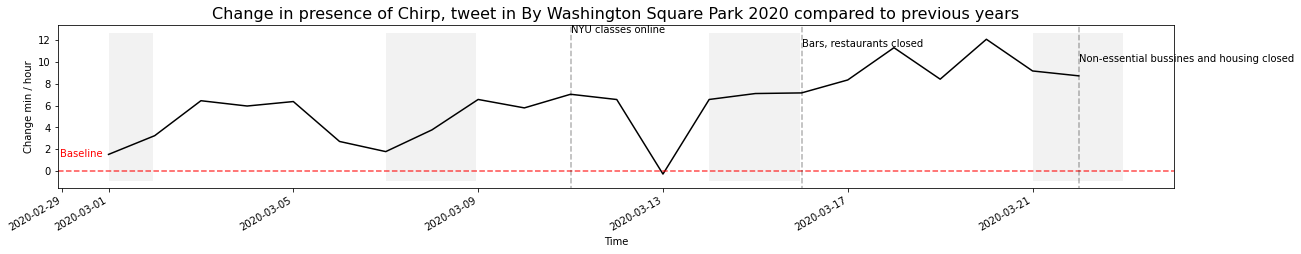

In [28]:
for sound_class in df['sound_class'].unique():
    print(sound_class)
    _df_perclass = df[(df['sound_class']==sound_class)]#& (df['sensor_id'].isin(['b827eb0fedda', 'b827eb815321','b827eb8e2420']))]
    _df_perclass = compute_presence(_df_perclass, quick_ths)
    _df_perclass = add_aligned_hour_index(_df_perclass)
    _df_perclass['presence_min'] = _df_perclass['presence']*60
    _df_change = calculate_rolling_change_in_value(_df_perclass, var_column='sound_class', value_column='presence_min',
                                                   rolling_interval=15, on='aligned_day_index', center=True)
    address = 'By Washington Square Park'#list(near_park[near_park['node_id'].str.contains(sensor_id)]['address'])[0]
    _df_ = _df_change[(_df_change['year']==2020)]
    ax = lineplot(_df_.groupby(['date', 'sensor_id'])['rolling_value_change'].mean().reset_index(),
                  'date', 'rolling_value_change', 
                  title=f'Change in presence of {sound_class} in {address} 2020 compared to previous years',
                  ylabel='Change min / hour',   
             important_dates=important_dates, baseline=True)
    add_in_weekend_shading(ax, _df_)
    plt.savefig(f'{sound_class}_bird_plot.pdf')
    plt.show()

## Compute combined change all classes

In [29]:
def compute_combined_presence(df, thresholds=None, classes_to_combine=None):
    '''
    Function to compute the combined presence of the different yamnet bird sound classes given their likelihood
    and an adequate threshold. The presence is averaged at the hour level.

    Parameters
    ----------
    df (pandas DataFrame):
        DataFrame containing the classes likelihood.
    thresholds (dict):
        Dictionary with customize thresholds, format is {sound_class:threshold_value}.
        By default the presence is computed with a threshold of 0.2.

    Returns
    -------
    df (pandas DataFrame) with an extra column 'presence'

    '''

    df = df.copy()

    df['presence'] = (df['likelihood'] > 0.025).astype('float')

    if thresholds is not None:
        for sound_class in thresholds.keys():
            df.loc[df['sound_class'] == sound_class, 'presence'] = (df['likelihood'] >
                                                                   thresholds[sound_class]).astype('float')
            
    # aggregate using OR
    if classes_to_combine is not None:
        id_cols = ['hour_of_day', 'date', 'datetime', 'year', 'weekday', 'sensor_id',
               'year_group', 'period']
        _df = df.pivot_table(index=id_cols, columns='sound_class', values='presence').reset_index()
        _df = _df[id_cols + classes_to_combine]
        _df['presence'] = (_df[classes_to_combine].any(axis=1)).astype(float)
        _df['sound_class'] = 'all'
        df = _df.copy()

    df_sum = df.groupby(['sensor_id', 'year', 'weekday', 'date', 'hour_of_day', 'sound_class', 'period',
                        'year_group'])['presence'].mean().reset_index()
    df_sum['datetime'] = df_sum['date'] + pd.Series([pd.DateOffset(hour=h) for h in df_sum['hour_of_day']])

    return df_sum

# Plot predictions jointly with SPL

In [30]:
from analysis_yamnet import load_spl_data, limit_to_dates
spl_hdf5_path = '/scratch/mf3734/share/arise/data/spl/spl.h5'
df_spl = load_spl_data(spl_hdf5_path)

FileNotFoundError: File /scratch/mf3734/share/arise/data/spl/spl.h5 does not exist

In [ ]:
len(df_spl.sensor_id.unique())

In [ ]:
[df_spl[df_spl['year']==year]['datetime'].min() for year in range(2017,2021)]

In [ ]:
[df_spl[df_spl['year']==year]['datetime'].max() for year in range(2017,2021)]

In [ ]:
_df_all = compute_combined_presence(df, thresholds={c:quick_ths[c] for c in classes_names_selection},
                                    classes_to_combine=classes_names_selection)
_df_all = add_aligned_hour_index(_df_all)
_df_all['presence_min'] = _df_all['presence']*60
_df_change = calculate_rolling_change_in_value(_df_all, var_column='sound_class', value_column='presence_min',
                                               rolling_interval=15, on='aligned_day_index', center=True)
_df_ = _df_change[(_df_change['year']==2020)]

In [ ]:
# _df_spl = limit_to_dates(df_spl, df_spl['date'], '02-24', '05-11')
_df_spl = limit_to_dates(df_spl, df_spl['date'], '02-24', '03-24')
_df_spl = add_aligned_hour_index(_df_spl)
_df_spl = calculate_rolling_change_in_value(_df_spl, rolling_interval=15, on='aligned_day_index', center=True)
_df_spl_ = _df_spl[(_df_spl['year']==2020) & (_df_spl['hour_of_day']>4)&(_df_spl['hour_of_day']<7)]

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18,6))
ax = lineplot(_df_.groupby(['date', 'sensor_id'])['rolling_value_change'].mean().reset_index(),
             'date', 'rolling_value_change', 
                  title='Change in presence of birds in {} 2020 compared to previous years (2017-2019)'.format(address),
                  ylabel='Change min / hour',   
             important_dates=important_dates, baseline=True, new_plot=False, ax=ax1, 
              palette=sns.xkcd_palette(['green']))
lineplot(_df_spl_.groupby(['date', 'sensor_id'])['rolling_value_change'].mean().reset_index(),
         'date', 'rolling_value_change', 
              title='Change in SPL levels {} 2020 compared to previous years (2017-2019)'.format(address),
              ylabel='Change dB',   
         important_dates=important_dates, baseline=True, new_plot=False, ax=ax2, palette=sns.xkcd_palette(['red']))
add_in_weekend_shading(ax1, _df_)
add_in_weekend_shading(ax2, _df_)
plt.savefig('bird_act_vs_noise_.pdf', bbox_inches='tight')